In [20]:
import torch
import tensorflow_datasets as tfds
import tensorflow as tf
import argparse
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.autograd import Variable
from itertools import product
from sklearn.decomposition import PCA
import seaborn as sns


In [2]:
def extract_patch_data(datasets,depth): 
    #make index for the data patches
    factor=np.power(2,depth)
    length=datasets.shape[2]/factor
    idx1=range(0,int(length),2)
    idx2=[i+2 for i in idx1]
    #iterate and generate list over the indexes
    data_=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),\
                                                              zip(idx1,idx2))]
    data_=np.array(data_)
    data=np.reshape(data_,(data_.shape[0]*data_.shape[1],data_.shape[2],2,2)) 
    return data

  
def pca_aug(data_in):
    # data reshape for PCA
    data=np.reshape(data_in,(data_in.shape[0],-1))
    # mean removal
    mean = np.mean(data, axis=0)
    datas_mean_remov = data - mean
    # PCA, retain all components
    pca=PCA(n_components=2)
    pca.fit(datas_mean_remov)
    comps=pca.components_
    # augment
    comps_aug=[vec*(-1) for vec in comps[:-1]]
    comps_complete=np.vstack((comps,comps_aug))
    return comps_complete

def conv_filt(aug_filt_array):
    shape=aug_filt_array.shape[1]/4
    num=aug_filt_array.shape[0]
    filt=np.reshape(aug_filt_array,(num,int(shape),4))
    filters=np.reshape(filt,(num,int(shape),2,2))
    return filters

def conv_relu(filters,datasets,stride=2):
    # torch data change
    filters_t=torch.from_numpy(filters)
    datasets_t=torch.from_numpy(datasets)

    # Variables
    filt=Variable(filters_t).type(torch.FloatTensor)
    data=Variable(datasets_t).type(torch.FloatTensor)

    # Convolution
    output=F.conv2d(data,filt,stride=stride)

    # Relu
    relu_output=F.relu(output)

    return relu_output,filt

In [3]:
def single_saak_trans(datasets=None,depth=0):
    



    data_flatten = extract_patch_data(datasets,depth)

    #PCA and augmentation
    comps_complete = pca_aug(data_flatten)


    # get filters
    filters = conv_filt(comps_complete)


    # output Saak coefficients and filters
    relu_output,filt = conv_relu(filters,datasets,stride=2)

    data = relu_output.data.numpy()


    print('saak transformation Complete!{}')

    return data,filt,relu_output

In [4]:
ds_train = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1,\
                                   as_supervised=False))

'''EXTRRACT DATA AS NUMPY'''

def extract_dataset():

    ds_t = ds_train['image'][:1000]
    ds_t = ds_t.reshape(ds_t.shape[0],1,28,28)
    return ds_t


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
def milti_saak_(num_stages):
  filters = []
  outputs = []

  data = extract_dataset()
  dataset = data
  for i in num_stages:
      print ('{} stage of saak transform: '.format(i))
      data,filt,output=single_saak_trans(data,depth=i)
      filters.append(filt)
      outputs.append(output)
      print ('')


  return dataset,filters,outputs

In [6]:
dataset,filters,outputs=milti_saak_([1,2])

1 stage of saak transform: 
saak transformation Complete!{}

2 stage of saak transform: 
saak transformation Complete!{}



I write the function $toy\_recon$ for reconstructing the image from the SAAK Features, got from the last stage in a multistage SAAK transform. I first take reversed arrray of the output and filter of the particular stage of SAAK transform and do a transposed convolution (Deconvolution) to construct the reconstructed image.  

In [7]:
def toy_recon(outputs,filters):
    # reverse the output start reconstruction from second last stage

    outputs=outputs[::-1][1:]
    filters=filters[::-1][1:] 
    num=len(outputs)
    data=outputs[0]
    for i in range(num):
        data = F.conv_transpose2d(data, filters[i], stride=2)

    return data

In [8]:
# Making numpy array of reconstructed images
data_rec = toy_recon(outputs,filters)


In [13]:
# function to display image from numpy array of reconstructed image

def show_reconstructed(inv,n):
    inv_img=inv.data.numpy()[n][0]
    plt.imshow(inv_img)
    plt.gray()
    plt.show()

In [14]:
# show actual:
def show_actual(n):
    inv_img= np.squeeze(ds_train['image'][n], axis=-1)
    plt.imshow(inv_img)
    plt.gray()

    plt.show()

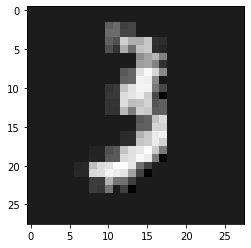

In [15]:
show_reconstructed(data_rec,55)

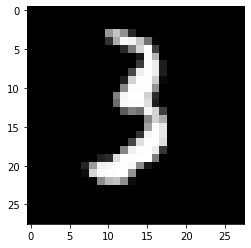

In [16]:
show_actual(55)

In [17]:
#calculating PSNR for 1000 random images in mnist dataset
import math
def PSNR():
  psnr = []
  for i in range(len(ds_train['image'][:1000])):
    m = np.mean((data_rec.data.numpy()[i] - np.squeeze(ds_train['image'][i], axis=-1)) ** 2)
    psnr.append(20 * math.log10(225 / math.sqrt(m)))

  return psnr



In [18]:
psnr_list = PSNR()

In [19]:
psnr_list

[19.49972741799652,
 20.60848897627047,
 18.055344409383185,
 20.144009023013425,
 17.385527198419393,
 21.217937186025857,
 18.302148801729846,
 20.20123105737931,
 21.267362338424984,
 19.112567893115504,
 19.2688661851439,
 17.90227560636245,
 20.109047707412877,
 19.907484354437628,
 17.28414864999563,
 18.155645582119853,
 18.779558173087125,
 18.610618314209223,
 17.75086621563636,
 21.135321914161914,
 16.718188689597184,
 18.333356251275145,
 20.147869600965134,
 18.00709455157472,
 19.252147737140916,
 20.031625093216974,
 16.682370459705595,
 18.803023950566345,
 19.840347569655773,
 20.88505041471663,
 16.51461904255001,
 18.975410415032886,
 19.728351417349607,
 17.20388598464464,
 19.00046789713466,
 18.730815102085607,
 16.623375573658507,
 18.081702182597432,
 17.671417621078113,
 19.201496293818966,
 18.75777509672465,
 18.941997763031075,
 18.474670338762976,
 16.234315790214385,
 20.012792559081753,
 21.570116847666352,
 20.502324891735636,
 18.91669542098494,
 18.387

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'PSNR score for 1000 images from minst dataset')

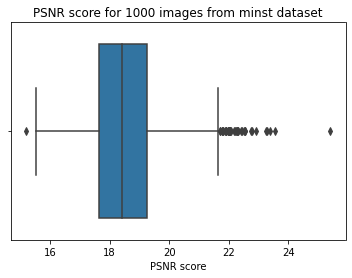

In [26]:

ax = sns.boxplot(psnr_list)
ax.set(xlabel='PSNR score')
ax.set_title('PSNR score for 1000 images from minst dataset')
